In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
batch_size = 64
img_height = 224
img_width = 224
image_size = (img_width, img_height)
validation_split = 0.33
data_dir = "data/images_is_flower/train"
num_classes = 1

In [3]:
def get_dataset_from_directory(type, seed=123):
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset=type,
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

train_ds = get_dataset_from_directory("training")
val_ds = get_dataset_from_directory("validation")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 831 files belonging to 2 classes.
Using 557 files for training.
Found 831 files belonging to 2 classes.
Using 274 files for validation.


In [4]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [5]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [6]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs 
)

Epoch 1/5
9/9 [==============================] - 48s 3s/step - loss: 0.8643 - binary_accuracy: 0.5698 - val_loss: 0.6512 - val_binary_accuracy: 0.7153
Epoch 2/5
9/9 [==============================] - 18s 2s/step - loss: 0.5851 - binary_accuracy: 0.7030 - val_loss: 0.5679 - val_binary_accuracy: 0.7117
Epoch 3/5
9/9 [==============================] - 18s 2s/step - loss: 0.5927 - binary_accuracy: 0.7017 - val_loss: 0.4564 - val_binary_accuracy: 0.7701
Epoch 4/5
9/9 [==============================] - 18s 2s/step - loss: 0.4555 - binary_accuracy: 0.7929 - val_loss: 0.4331 - val_binary_accuracy: 0.7993
Epoch 5/5
9/9 [==============================] - 18s 2s/step - loss: 0.3862 - binary_accuracy: 0.8304 - val_loss: 0.4223 - val_binary_accuracy: 0.8029


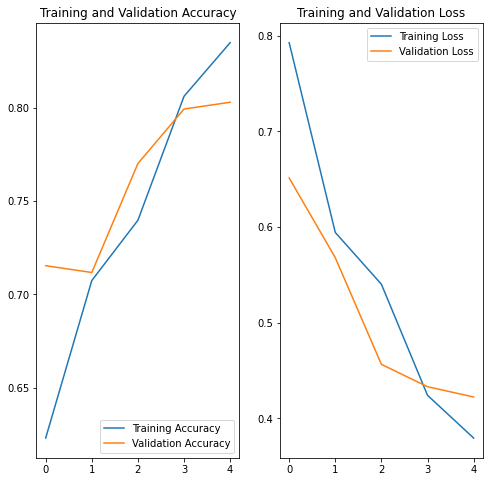

In [7]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
img_filenames = glob(data_dir + '/0/*')[0:30]

images = []
for image in img_filenames:
    img = keras.preprocessing.image.load_img(
        image, target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    images.append(img_array)

images = np.vstack(images)
predictions = model.predict(images)
score = predictions > 0.5
false_negatives = (np.array(images)[ score[:,0] ])

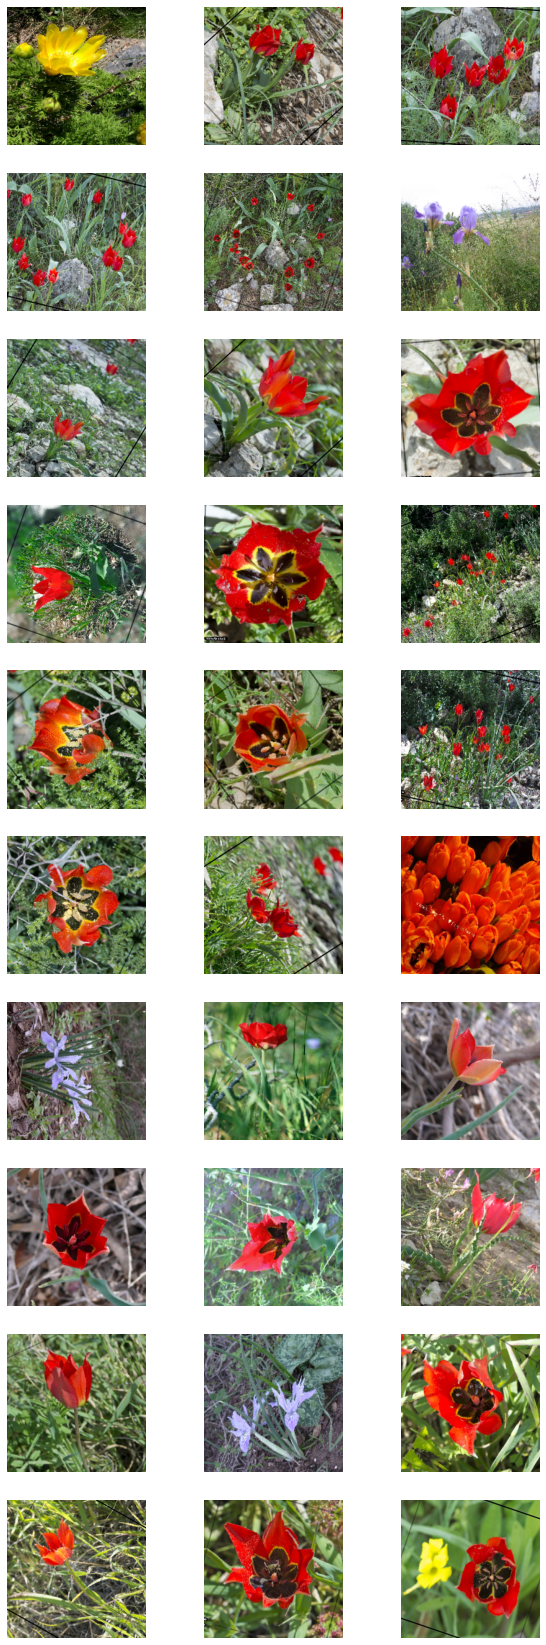

In [39]:
plt.figure(figsize=(10, 30))
for i,image in enumerate(images):
    ax = plt.subplot(10, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')